# Libraries

In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Data Information

In [2]:
train_file_id = '1SsvmjOOn2rIWDUPfQ6xJGFwWbVoxTd-2'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False)
df = pd.read_csv(train_output_file, sep = '\t')

Downloading...
From: https://drive.google.com/uc?id=1SsvmjOOn2rIWDUPfQ6xJGFwWbVoxTd-2
To: /content/train.csv
100%|██████████| 515k/515k [00:00<00:00, 34.2MB/s]


In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
for col in obj:
  print(f"====={col}=====")
  unique_values = df[col].unique()
  n_unique_values = df[col].nunique()
  value_counts = df[col].value_counts()

  print(f"Unique values in {col}: {unique_values}")
  print(f"Number of unique values in {col}: {n_unique_values}\n")
  print(f"Value counts in {col}:\n{value_counts}\n")

=====rating=====
Unique values in rating: [5 4 3 2 1]
Number of unique values in rating: 5

Value counts in rating:
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64

=====feedback=====
Unique values in feedback: [1 0]
Number of unique values in feedback: 2

Value counts in feedback:
feedback
1    2893
0     257
Name: count, dtype: int64



# Data Cleaning

In [6]:
df = df.dropna()

In [7]:
df.duplicated().sum()

715

# EDA Before Data Preprocessing

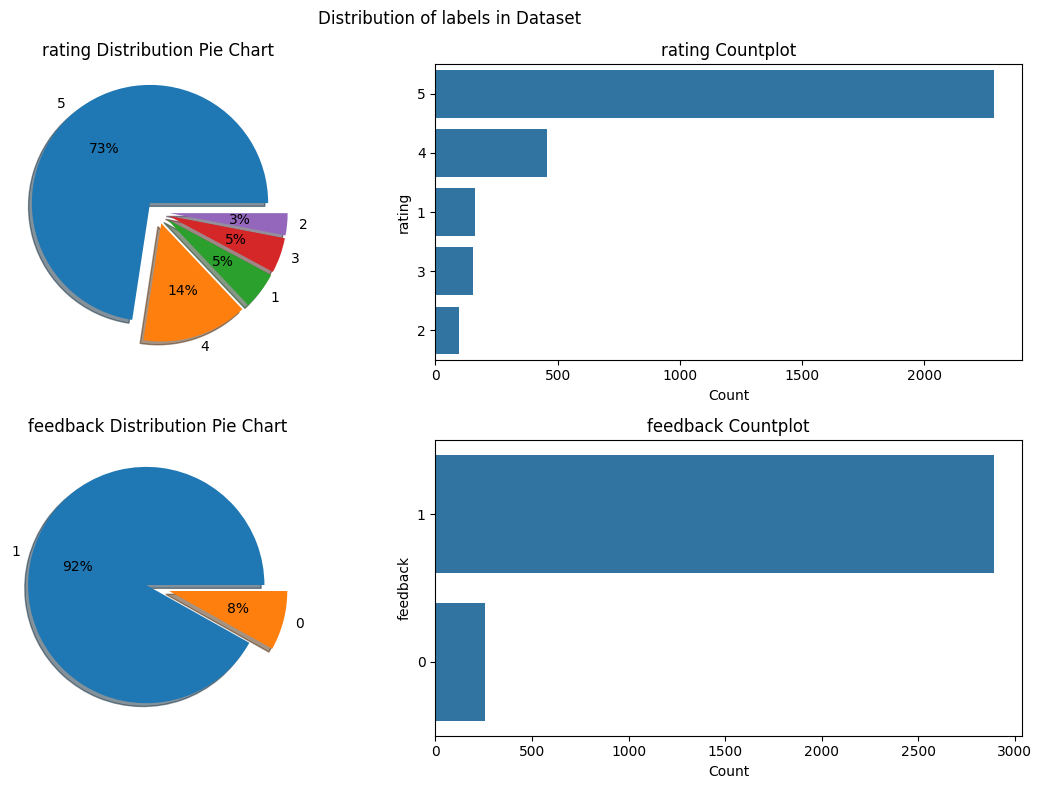

In [8]:
fig, axes = plt.subplots(len(obj), 2, figsize = (12, 8))

for i, col in enumerate(obj):
  ax = axes[i, 0]
  ax.pie(
      df[col].value_counts(),
      shadow = True,
      explode = [0.1 for _ in range(df[col].nunique())],
      autopct='%1.f%%',
      labels = df[col].value_counts().index
  )

  ax.set_aspect('equal')
  ax.set_title(f'{col} Distribution Pie Chart')

  ax1 = axes[i, 1]
  sns.countplot(y = col, ax = ax1, order = df[col].value_counts().index, data = df)
  ax1.set_xlabel('Count')
  ax1.set_ylabel(col)
  ax1.set_title(f'{col} Countplot')

fig.suptitle('Distribution of labels in Dataset')
plt.tight_layout()
plt.show()

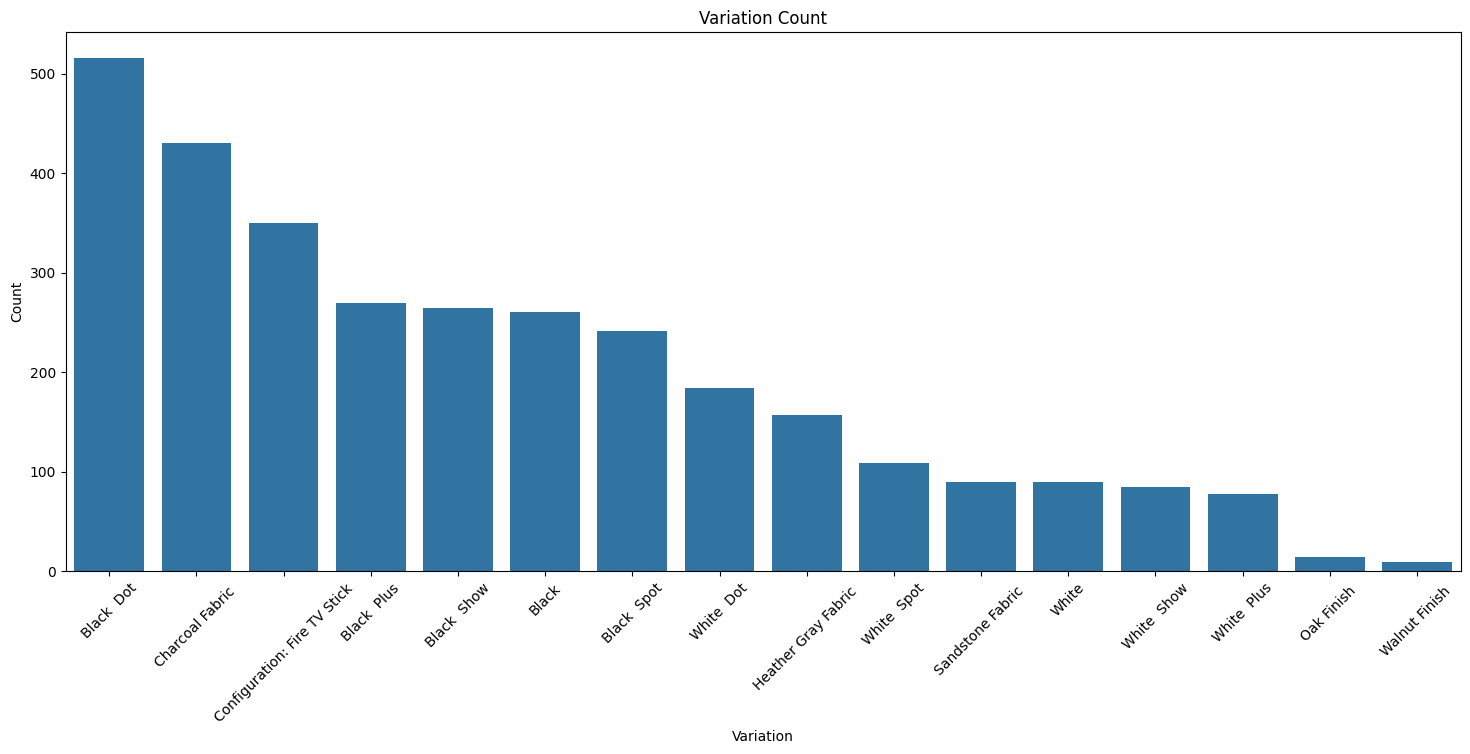

In [9]:
order = df['variation'].value_counts().index

plt.figure(figsize = (18,7))
sns.countplot(x='variation', data = df, order = order)
plt.xlabel('Variation')
plt.ylabel('Count')
plt.title('Variation Count')

plt.xticks(rotation=45)
plt.show()

# EDA After Time Feature Engineering

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')
# df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()

In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback,month,day,weekday
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday


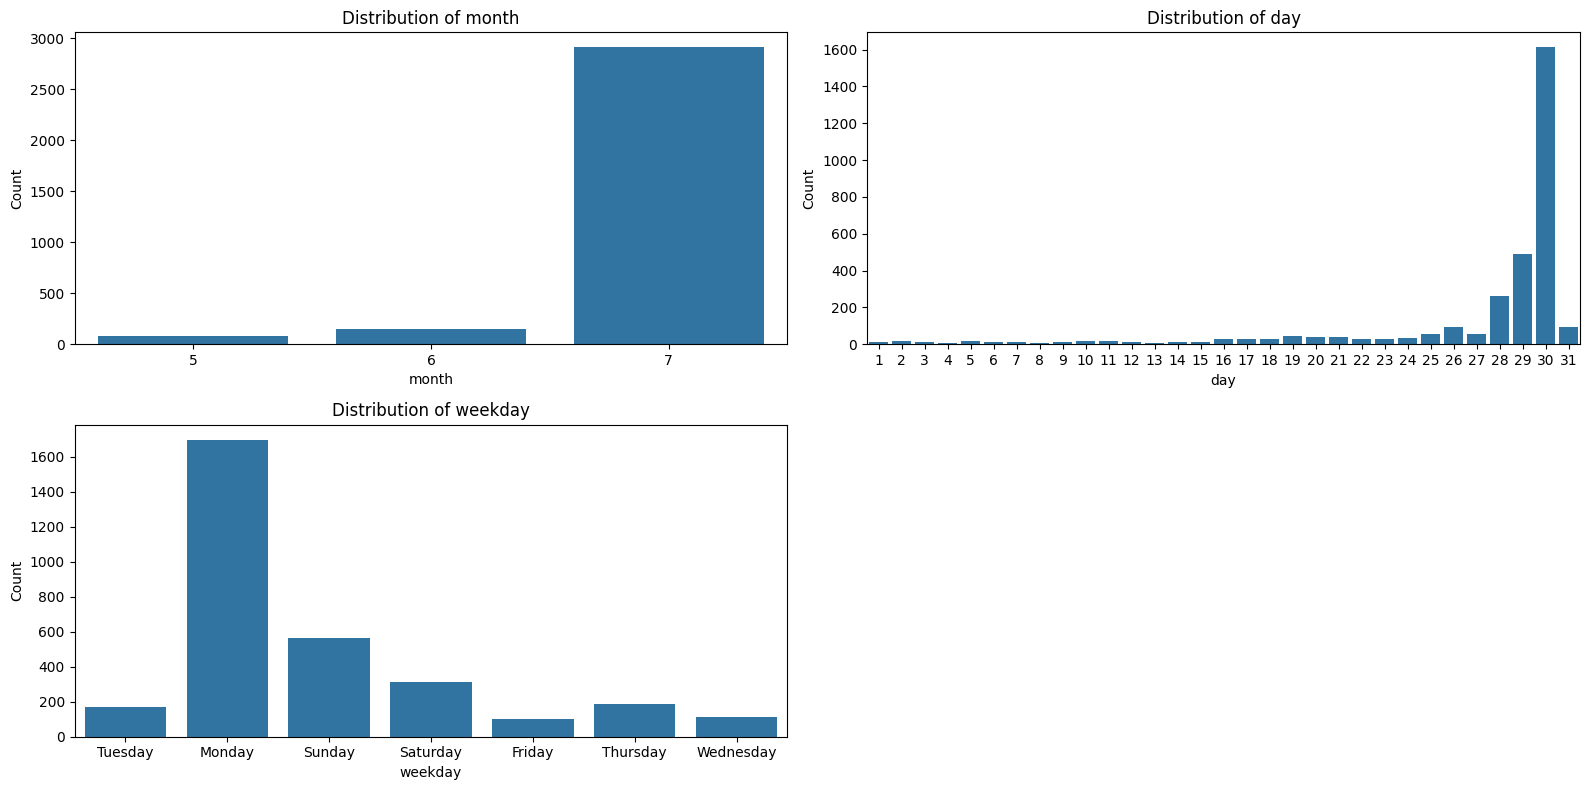

In [12]:
time_cols = ['month', 'day', 'weekday']
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(time_cols):
  ax = sns.countplot(x=col, data=df, ax=axes[i])
  ax.set_xlabel(col)
  ax.set_ylabel('Count')
  ax.set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Lenght Counts

## By feedback

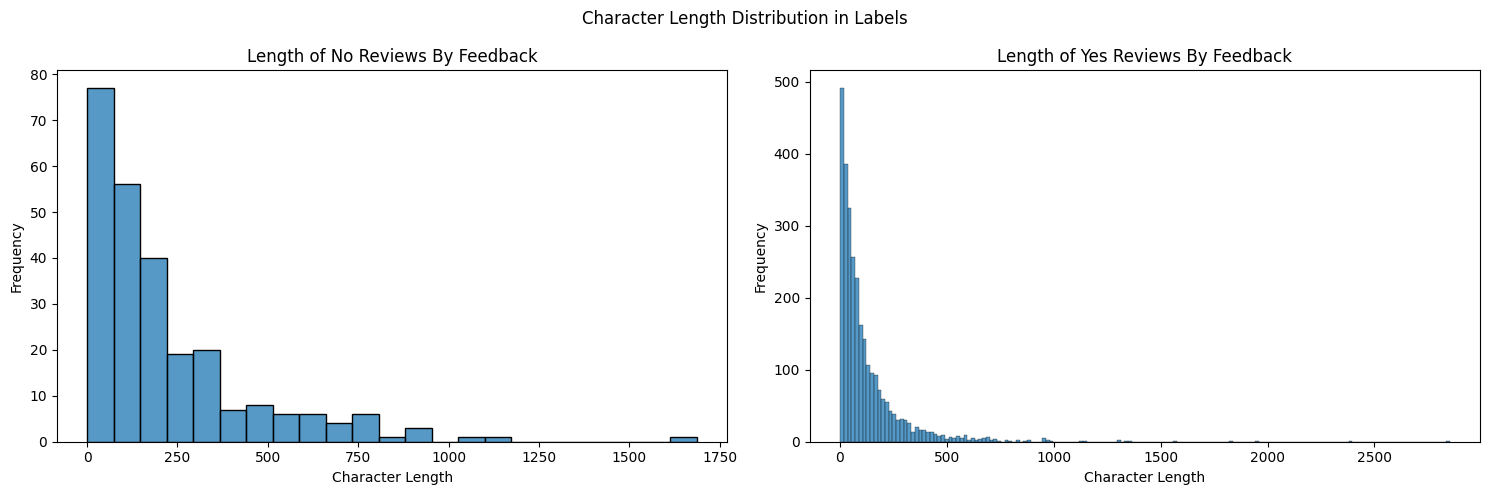

In [13]:
labels = [0, 1]
label_names = ["No", "Yes"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, label in enumerate(labels):
  length_text = df[df['feedback'] == label]['verified_reviews'].str.len()
  ax = sns.histplot(length_text, ax=axes[i])
  ax.set_title(f'Length of {label_names[label]} Reviews By Feedback')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

fig.suptitle('Character Length Distribution in Labels')
plt.tight_layout()
plt.show()

### By rating

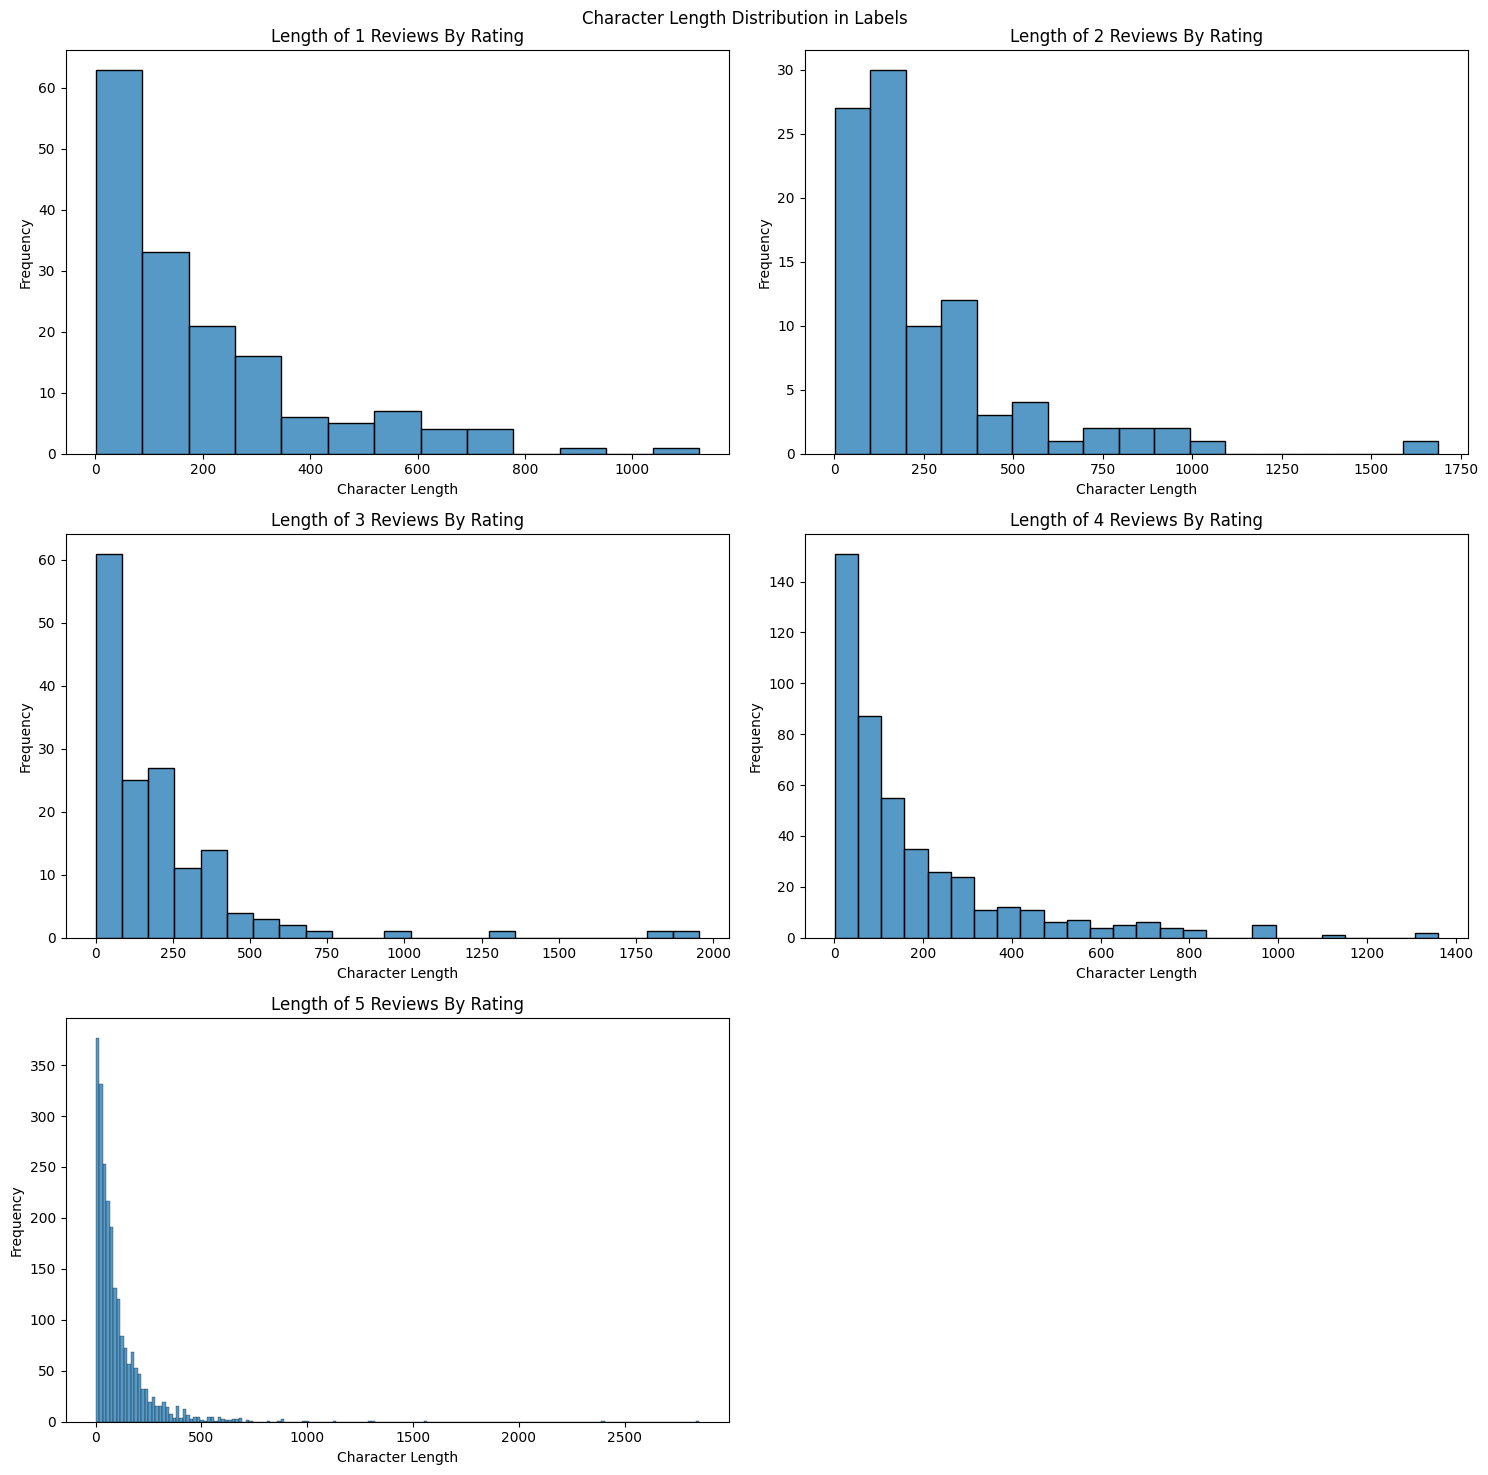

In [14]:
labels = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, label in enumerate(labels):
  length_text = df[df['rating'] == label]['verified_reviews'].str.len()
  ax = sns.histplot(length_text, ax=axes[i])
  ax.set_title(f'Length of {label} Reviews By Rating')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

fig.suptitle('Character Length Distribution in Labels')
plt.tight_layout()
plt.show()

## Word Count

### By feedback

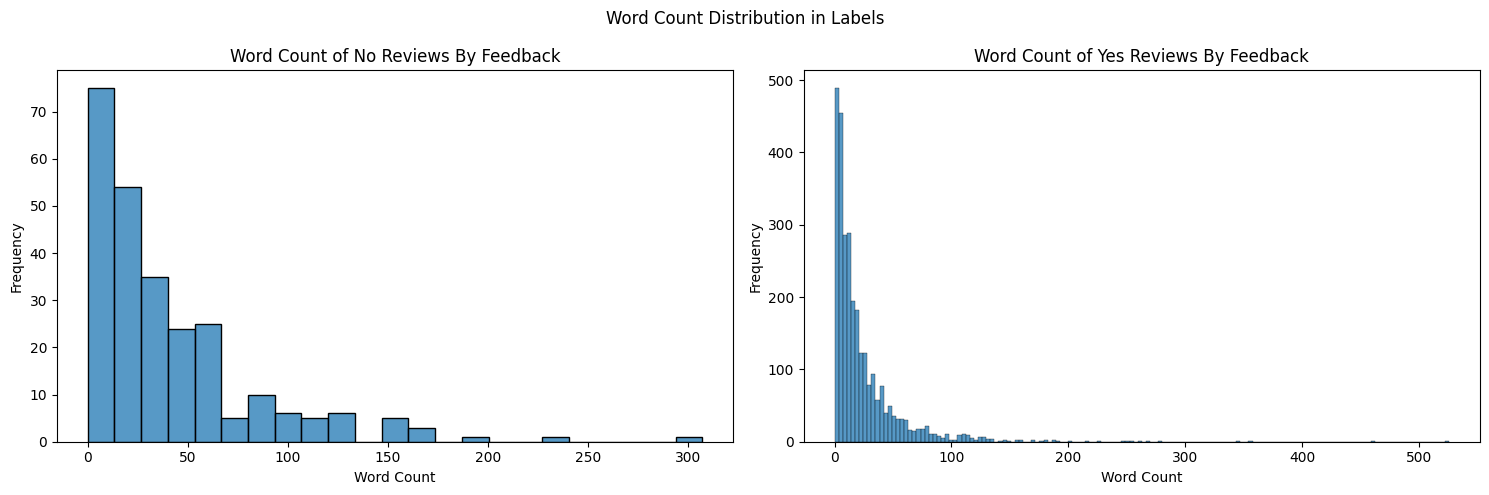

In [15]:
labels = [0, 1]
label_names = ["No", "Yes"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for i, label in enumerate(labels):
  word_count = df[df['feedback'] == label]['verified_reviews'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i], kde=False)
  ax.set_title(f'Word Count of {label_names[label]} Reviews By Feedback')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Count Distribution in Labels')
plt.tight_layout()
plt.show()

## Rating

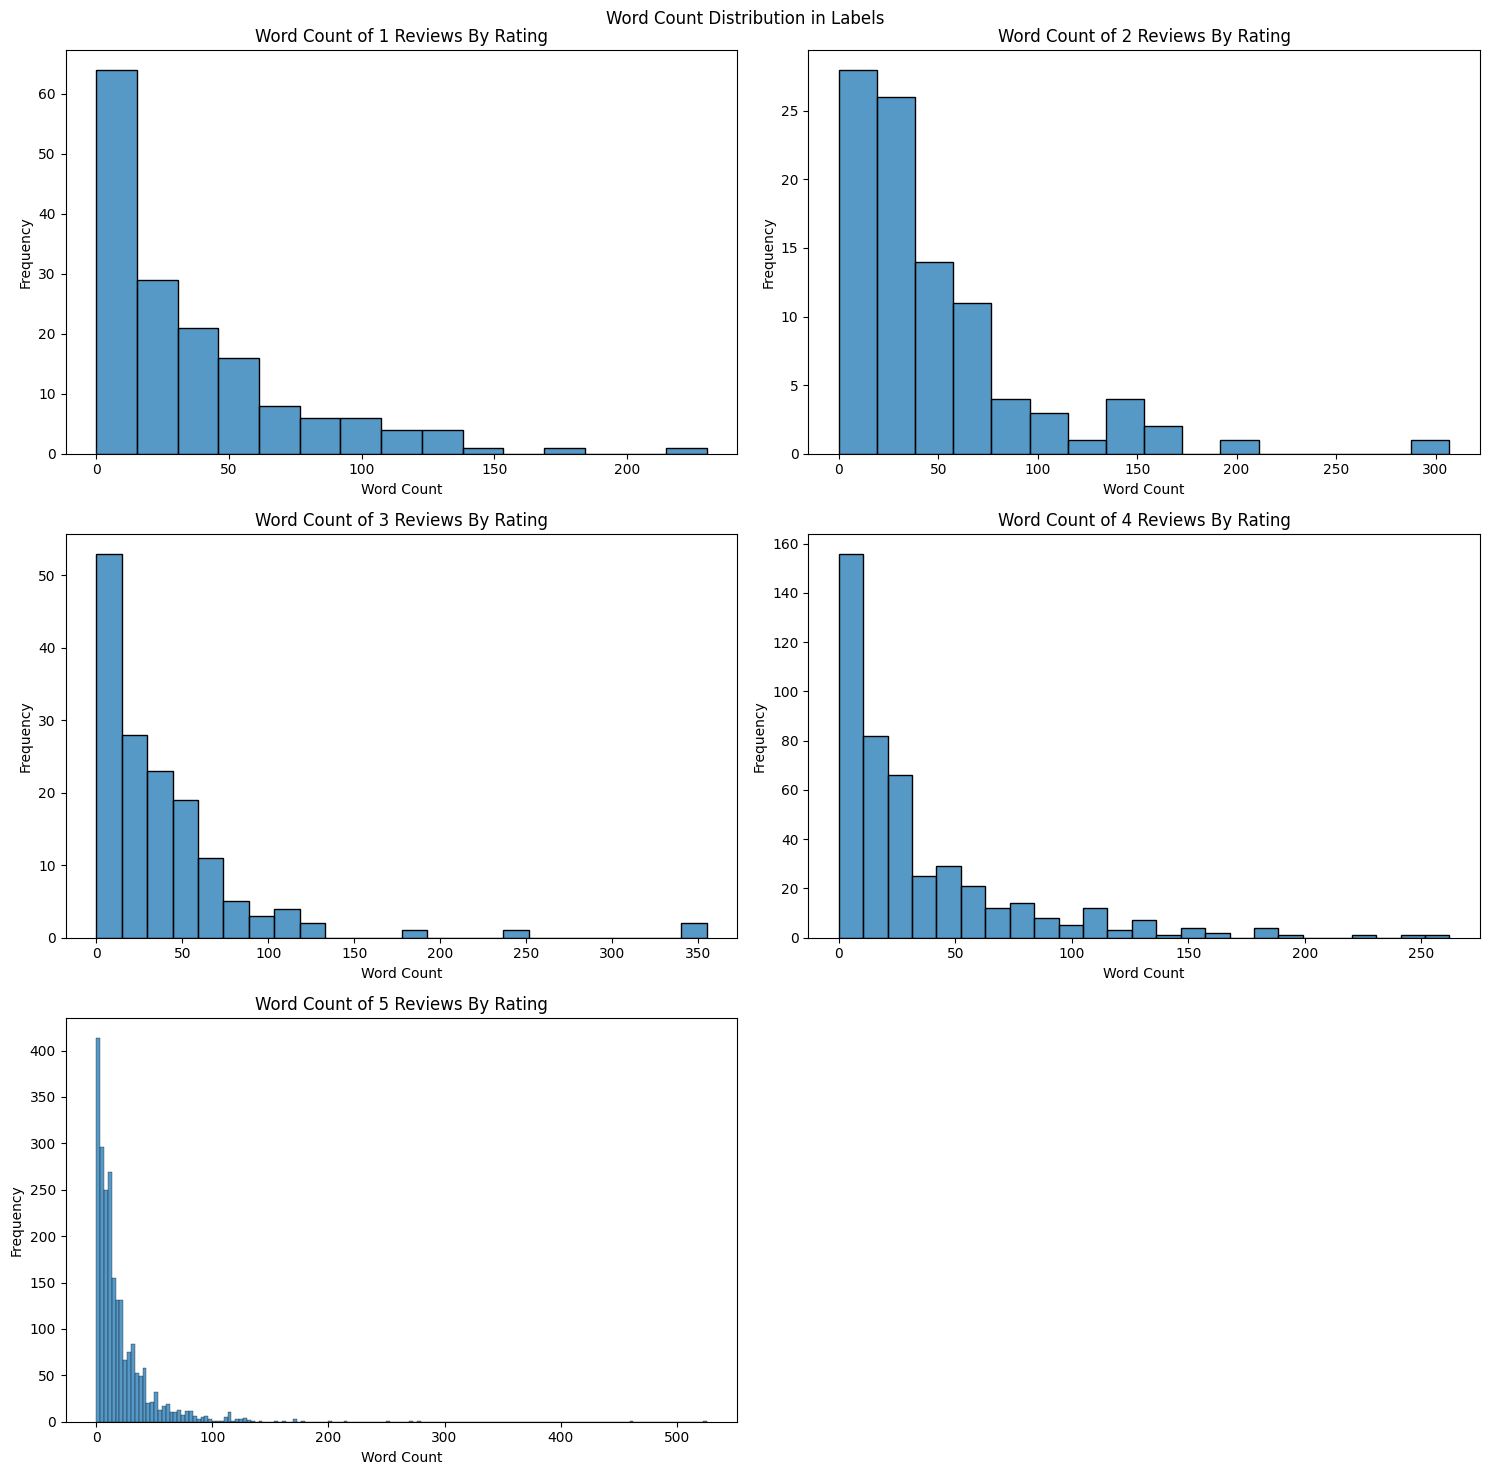

In [16]:
labels = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, label in enumerate(labels):
  word_count = df[df['rating'] == label]['verified_reviews'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i], kde=False)
  ax.set_title(f'Word Count of {label} Reviews By Rating')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

for j in range(len(labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Word Count Distribution in Labels')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

## Text Cleaning

In [18]:
import re
import string

punc = string.punctuation

def text_cleaning(text):
    # Step 1: Transform to lowercase
    text = text.lower()

    # Step 2: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Step 3: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 4: Remove punctuation
    text = "".join([i for i in text if i not in punc])

    # Step 5: Remove emoticons and emojis
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text

df['clean_verified_reviews'] = df['verified_reviews'].apply(text_cleaning)
df.head()

,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,love my echo
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,loved it
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,sometimes while playing a game you can answer ...
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,i have had a lot of fun with this thing my yr...
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,music


## Tokenize

In [19]:
nltk.download('punkt')

def tokenize(text):
  token = word_tokenize(text)
  return token

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(tokenize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, my, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,"[loved, it]"
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, while, playing, a, game, you, can,..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[i, have, had, a, lot, of, fun, with, this, th..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


## Stopwords

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stopword(words):
  words = [word for word in words if len(word) > 2 and word not in stop_words]
  return words

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(stopword)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,[loved]
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, playing, game, answer, question, c..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[lot, fun, thing, old, learns, dinosaurs, cont..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


## Lemmatizer

In [21]:
nltk.download('wordnet')
lm = WordNetLemmatizer()

def lemmatizer(words):
  return [lm.lemmatize(word, pos = 'v') for word in words if len(word) > 2]

df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lemmatizer)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,rating,date,variation,verified_reviews,feedback,month,day,weekday,clean_verified_reviews
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,7,31,Tuesday,"[love, echo]"
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,7,31,Tuesday,[love]
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,31,Tuesday,"[sometimes, play, game, answer, question, corr..."
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,31,Tuesday,"[lot, fun, thing, old, learn, dinosaurs, contr..."
4,5,2018-07-31,Charcoal Fabric,Music,1,7,31,Tuesday,[music]


In [22]:
df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lambda x: " ".join(x))

all_reviews = ' '.join(df['clean_verified_reviews'].dropna())
words = all_reviews.split()
freq_comm = pd.Series(words).value_counts()
freq_comm

,count
love,1057
echo,856
great,717
use,675
work,644
...,...
goodsome,1
scream,1
newno,1
showno,1


## Remove rare words

In [23]:
rare_words = freq_comm[freq_comm == 1].index
df['clean_verified_reviews'] = df['clean_verified_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))

text = ' '.join(df['clean_verified_reviews'].dropna())
text_length = len(text)
print(f'Length of the combined text: {text_length}')

Length of the combined text: 234626


# WordCloud

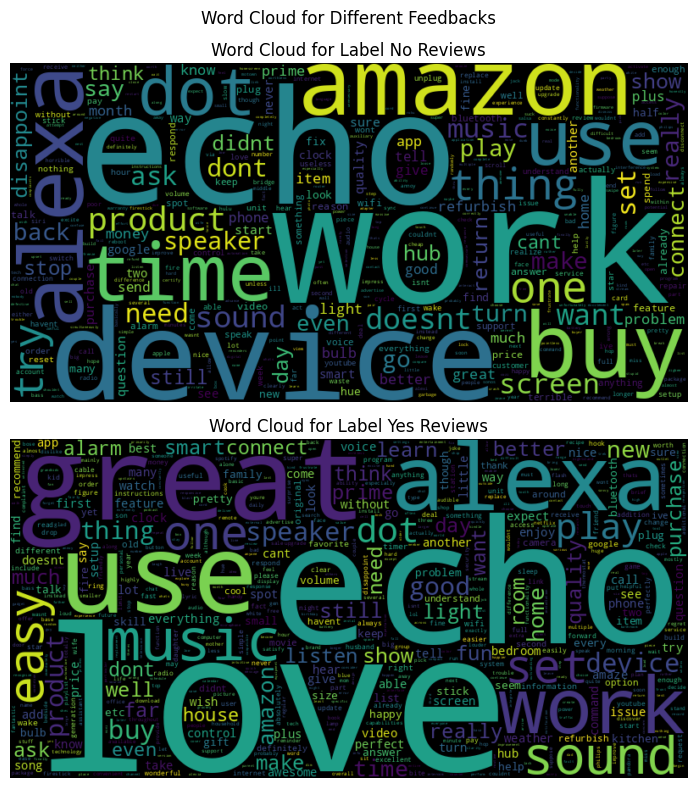

In [24]:
labels = [0, 1]
label_names = ['No', 'Yes']

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes = axes.flatten()

for i, lab in enumerate(labels):
  rev = ' '.join(df[df['feedback'] == lab]['clean_verified_reviews'].dropna())

  ax = axes[i]
  wordcloud = WordCloud(max_words=2000, width=800, height=400, collocations=False).generate(rev)

  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')
  ax.set_title(f"Word Cloud for Label {label_names[i]} Reviews")

fig.suptitle('Word Cloud for Different Feedbacks')
plt.tight_layout()
plt.show()

# Modelling

In [25]:
def plot_ngram(feedback, n):
  print("Feedback: ", feedback)

  temp_df = df[df['feedback'] == feedback]

  word_vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
  sparse_matrix = word_vectorizer.fit_transform(temp_df['clean_verified_reviews'])

  frequencies = sum(sparse_matrix).toarray()[0]

  feature_names = word_vectorizer.get_feature_names_out()
  freq_df = pd.DataFrame(frequencies, index=feature_names, columns=['frequency'])\
                .sort_values(by='frequency', ascending=False) \
                .reset_index() \
                .head(10)

  print(freq_df)

  plt.figure(figsize=(12, 8))
  plt.barh(freq_df['index'], freq_df['frequency'])
  plt.xlabel('Frequency')
  plt.ylabel('N-gram')
  plt.title(f'Top 10 {n}-grams for Feedbacks {feedback}')
  plt.gca().invert_yaxis()
  plt.show()

Feedback:  0
    index  frequency
0    work        102
1    echo         92
2     get         68
3  amazon         60
4     buy         57
5  device         54
6   alexa         54
7   would         53
8    time         50
9     use         47


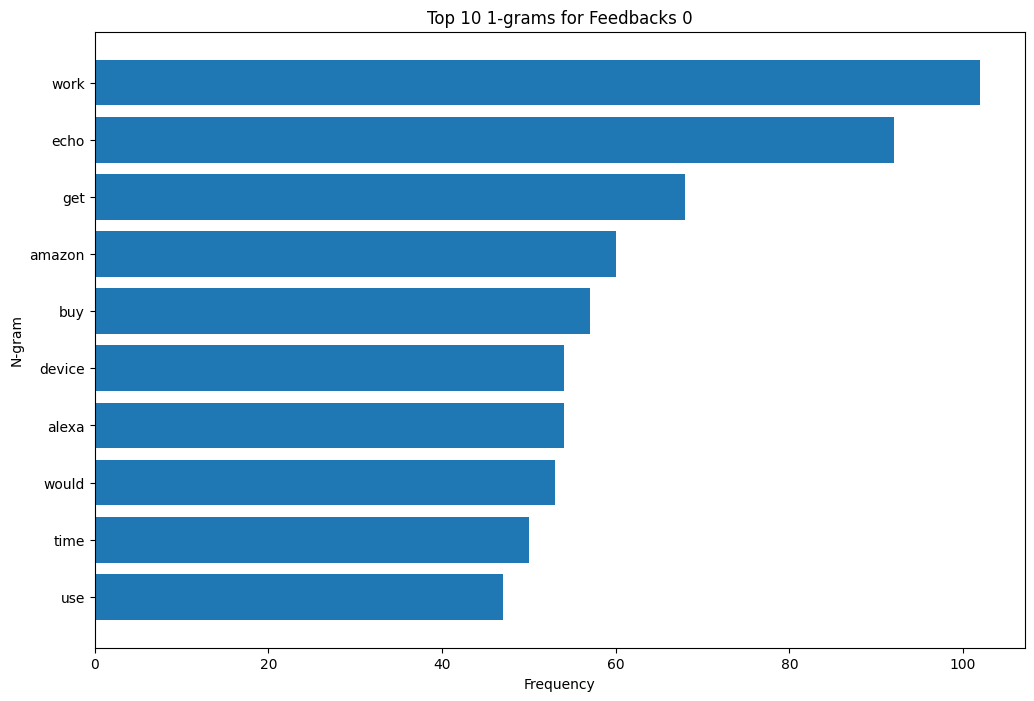

In [26]:
plot_ngram(feedback=0, n=1)

Feedback:  1
   index  frequency
0   love       1049
1   echo        764
2  great        699
3    use        628
4  alexa        559
5   work        542
6  music        494
7   like        483
8    get        429
9  sound        386


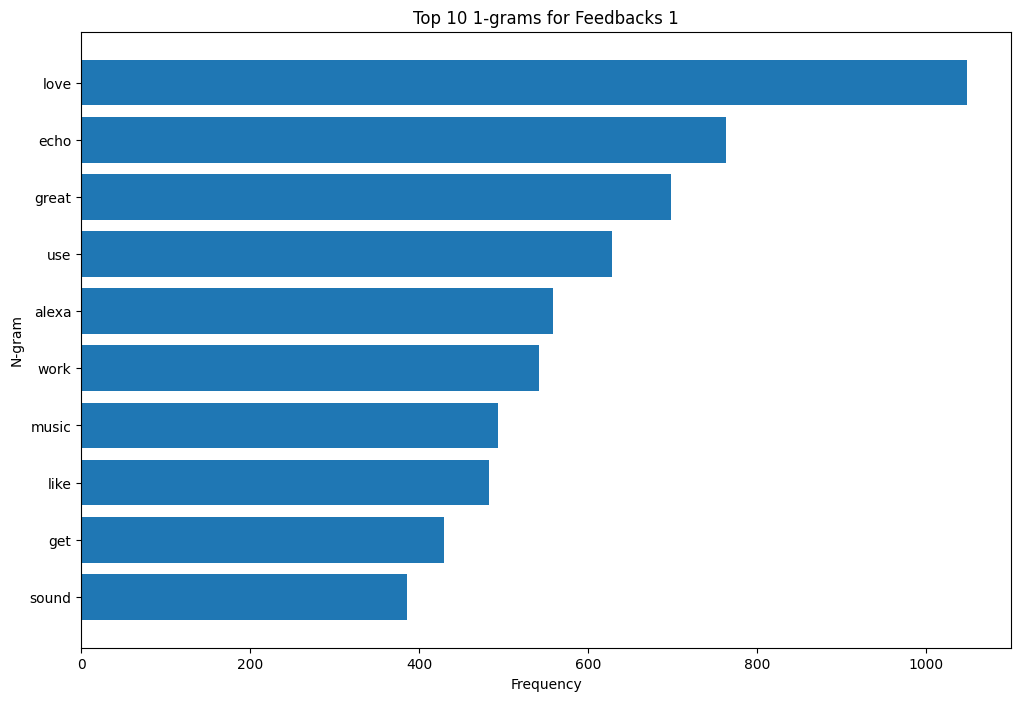

In [27]:
plot_ngram(feedback=1, n=1)

## Train Test Split

In [28]:
print("Total +ve reviews: ", df[df['feedback'] == 1]['clean_verified_reviews'].count())
print("Total -ve reviews: ", df[df['feedback'] == 0]['clean_verified_reviews'].count())

pos_train = df[df['feedback'] == 1][['clean_verified_reviews', 'feedback']].head(2025)
neg_train = df[df['feedback'] == 0][['clean_verified_reviews', 'feedback']].head(180)

pos_test = df[df['feedback'] == 1][['clean_verified_reviews', 'feedback']].tail(868)
neg_test = df[df['feedback'] == 0][['clean_verified_reviews', 'feedback']].tail(77)

Total +ve reviews:  2893
Total -ve reviews:  256


In [29]:
df_train = pd.concat([pos_train, neg_train]).sample(frac=1).reset_index(drop=True)
df_test = pd.concat([pos_test, neg_test]).sample(frac=1).reset_index(drop=True)

print("Train dataset head:")
print(df_train.head())
print("\nTest dataset head:")
print(df_test.head())

Train dataset head:
                              clean_verified_reviews  feedback
0                                 sad joke worthless         0
1  ive wait prime day purchase echo plus enjoy le...         1
2  ill return nothing annoy hub cant turn need hu...         0
3                                 home entertainment         1
4      echo work well able sync amazon music devices         1

Test dataset head:
                              clean_verified_reviews  feedback
0  small speaker tin sound great good bluetooth s...         1
1  great definitely get little old cant really re...         1
2  love product dislike cant sync apple music ale...         1
3  love firestick kid love talk alexa get weather...         1
4  like amazon fire stick use thank help call get...         1


In [30]:
X_train = df_train['clean_verified_reviews']
X_test = df_test['clean_verified_reviews']
y_train = df_train['feedback']
y_test = df_test['feedback']

In [31]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (2205, 1798)
Shape of X_test: (945, 1798)


In [32]:
word_dict = vectorizer.vocabulary_
print("First 20 words from vocabulary with indices:")
print({k: word_dict[k] for k in list(word_dict)[:20]})

First 20 words from vocabulary with indices:
{'sad': 1358, 'joke': 862, 'worthless': 1775, 'ive': 856, 'wait': 1712, 'prime': 1224, 'day': 398, 'purchase': 1247, 'echo': 494, 'plus': 1183, 'enjoy': 523, 'learn': 903, 'alexa': 49, 'new': 1047, 'sonos': 1463, 'one': 1085, 'dot': 476, 'make': 952, 'really': 1277, 'nice': 1052}


In [33]:
def modelling(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print('Accuracy:', accuracy_score(y_test, y_pred))
  print('F1 Score:', f1_score(y_test, y_pred))

In [34]:
for c in [0.01, 0.02, 0.05, 0.25, 0.5, 0.75, 1]:
  lr = LogisticRegression(C=c, max_iter=1000)
  print(f'At C = {c}:-', end = ' ')
  modelling(lr, X_train, y_train, X_test, y_test)

At C = 0.01:- Accuracy: 0.9185185185185185
F1 Score: 0.9575289575289575
At C = 0.02:- Accuracy: 0.9185185185185185
F1 Score: 0.9575289575289575
At C = 0.05:- Accuracy: 0.9195767195767196
F1 Score: 0.9580573951434879
At C = 0.25:- Accuracy: 0.9227513227513228
F1 Score: 0.9596462133775566
At C = 0.5:- Accuracy: 0.9227513227513228
F1 Score: 0.9595119245701609
At C = 0.75:- Accuracy: 0.9248677248677248
F1 Score: 0.960577456968351
At C = 1:- Accuracy: 0.926984126984127
F1 Score: 0.9616453585325181


In [35]:
lr = LogisticRegression(C=1, max_iter=10000)
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

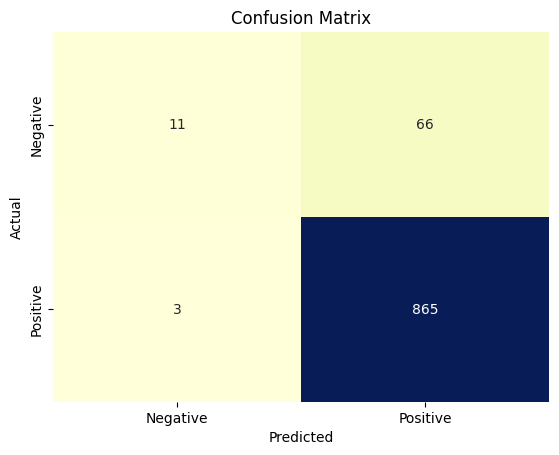

In [36]:
cm = confusion_matrix(y_test, prediction)

sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
accuracy_score = accuracy_score(y_test,prediction)
print("Accuracy of  Logistic Regression :", accuracy_score)

Accuracy of  Logistic Regression : 0.926984126984127


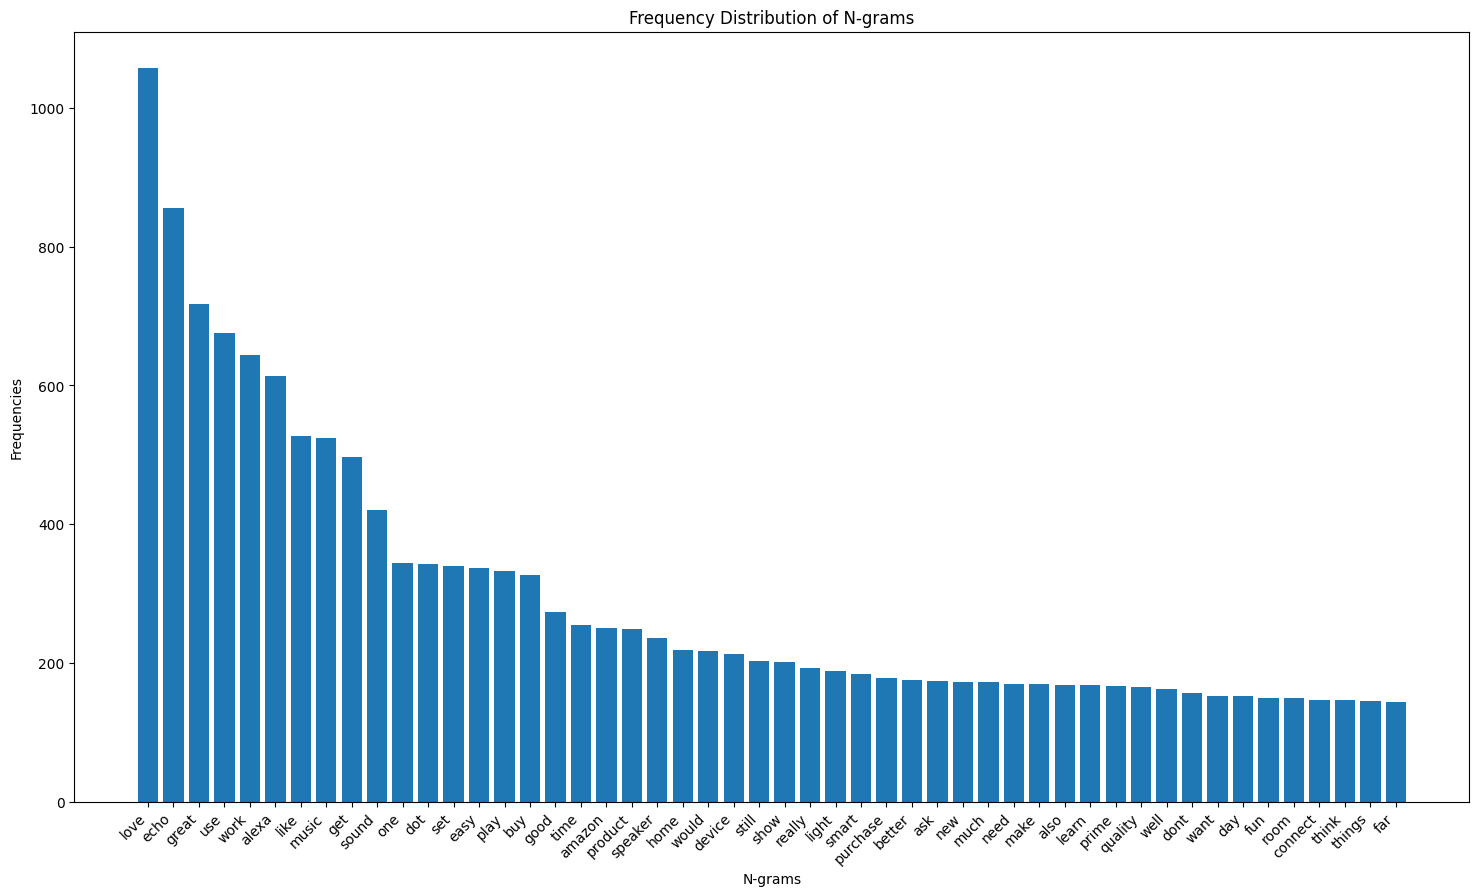

In [38]:
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(df['clean_verified_reviews'])

all_ngrams = vectorizer.get_feature_names_out()
all_counts = np.asarray(vect_texts.sum(axis=0)).flatten()

sorted_ngrams = sorted(zip(all_ngrams, all_counts), key=lambda x: x[1], reverse=True)
ngrams, counts = zip(*sorted_ngrams[:50])

plt.figure(figsize=(18, 10))
plt.bar(range(len(ngrams)), counts)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency Distribution of N-grams')
plt.xticks(range(len(ngrams)), ngrams, rotation=45, ha='right')
plt.show()

# Deep Learning